<h1>Data Processing</h1>

Ziel dieses Notebooks ist, die gescrapeten Daten so zu verarbeiten, dass Sie später thematisch durchsucht werden können. Ein Embeddingvektor liefert genau diese Funktion. Auf eine Anfrage hin wird der Abstand zwischen dem Embedding der Frage und den Embeddings aller anderen Dokumenten berechnet. Dann werden die Dokumente mit den kleinsten Abständen ausgewählt und dem LLM als Kontext mitgegeben. Mithilfe des Wissens dieser Dokumente soll dass LLM dann in der Lage sein die Frage korrekt zu beantworten.
Für die Embeddings benutzen wir [Google Bert](https://blog.google/products/search/search-language-understanding-bert/)

Beispiel:

User: Welche Dozenten unterrichten das Fach Grundlagen der Informatik?

System wählt besten 5 Dokumente aus 

    <Dokument 1>: ... betreute Prof. Dr. Löhr eine Batchelorarbeit in Grundlagen der Informatik...
    <Dokument 2>: Prof. Dr. Weber tel.: 013882664 email: weber@th.de Raum: HQ: 403, Fächer: Grundlagen der Informatik ...
    <Dokument 3> ...
    <Dokument 4> ...
    <Dokument 5> ...
    

Aus der Nutzeranfrage und den Dokumenten wird eine neue Query erstellt, die dem LLM dann final bereitgetellt wird. Diese sieht in etwa so aus:

    
    <Dokument 1>: ... betreute Prof. Dr. Löhr eine Batchelorarbeit in Grundlagen der     Informatik...
    <Dokument 2>: Prof. Dr. Weber tel.: 013882664 email: weber@th.de Raum: HQ: 403, Fächer: Grundlagen der Informatik ...
    <Dokument 3> ...
    <Dokument 4> ...
    <Dokument 5> ...

    Bitte beantworte folgende Frage unter der Berücksichtigung obiger Dokumente:
    Welche Dozenten unterrichten das Fach Grundlagen der Informatik?


Das LLM wird daraufhin hoffentlich korrekt eine Antwort liefern die ähnlich ist zu:

    A: An der TH Nürnberg Georg Simon Ohm unterichten die Professoren Prof. Dr. Löhr und Prof. Dr. Weber das Fach Grundlagen der Informatik.


In [3]:
import sqlite3
import pandas as pd
from transformers import BertModel, BertTokenizer
import torch
from tqdm import tqdm
from db_init import db_get_df

Zunächst laden wir die Daten aus der Datenbank. Dabei besitzt jedes Dokument als Metadaten den Titel der Webseite, den filenamen und den Text. Diese speichern wir uns in einen Pandas Dataframe

In [ ]:
database = 'html.sqlite'
sql = """
SELECT filename, title, text
FROM html_attrs
"""

con = sqlite3.connect(database)
df = pd.read_sql_query(sql, con)
con.close()

print(df.dtypes)
print(df["text"][3])

        Nuremberg Tech is a university with strong regional roots that understands its role in a globalized living, employment, and research community. Our aim is to offer our students degree programmes and a learning environment that provide access to applied research in today’s international context. Therefore, an international and intercultural orientation already forms a key component of life at the university; the development of this characteristic is anchored in our internationalisation strategy .  The following third-party funded projects support the implementation and continued development of the measures described in the strategy to advance internationality at Nuremberg Tech.                           Internationalisation squared (2022 – 2023)  The Internationalisation squared (INT 2 ) project implements and further develops Nuremberg Tech’s internationalisation strategy. Based on a comprehensive analysis of existing Erasmus university partnerships, three to five European part

Zur überprüfung der Texte können wir nun einmal eine Keywordsuche starten. Dieser Ansatz wird außerdem tiefer im Notebook [spacy_keywordextraction](./spacy_keywordextraction.ipynb) verfolgt.

In [ ]:
word = "Gallwitz"

[text for text in df["text"] if word in text][:5]

['       Voraussetzungen / Zielgruppe      Welche Studiengänge gibt es an der Fakultät Informatik?         Welche Studiengänge gibt es an der Fakultät Informatik?  Wirtschaftsinformatik Medieninformatik Informatik abgeschlossenes Bachelorstudium in - Wirtschaftsinformatik - Information Systems and Management - Information Technology in Business Computing - Computer Science in Business Computing abgeschlossenes Bachelorstudium in - Medieninformatik - Informatik - Computer Science - Information Technology abgeschlossenes Bachelorstudium in - Informatik - Computer Science - Information Technology mindestens 210 ECTS-Punkte, Nachqualifikation möglich mindestens 210 ECTS-Punkte, Nachqualifikation möglich mindestens 210 ECTS-Punkte, Nachqualifikation möglich Sechssemestrige Bachelorstudiengänge entsprechen 180 ECTS-Punkten. Daher sind im Masterstudium zusätzliche 30 ECTS-Punkte nachzuholen. Fehlende ECTS-Punkte können durch Nachqualifikation ausgeglichen werden. Zugangsvoraussetzung für den 

Jetzt werden wir für jedes Dokument ein eigenes Word embeddings erstellen. Dazu müssen wir zunächst das BERT Model laden.
Das BERT Model ist ein von Google trainiertes mehrschichtiges neuronales Netz, welches ursprünglich dafür entwickelt wurde, dass ???
es ist trainiert auf 10.000+ Büchern
es gibt Modelle "base" und "large"
uncased heißt ohne klein - Großschreibung

Wir brauchen zur vorbereitung die zusätzlichen Token
[SEP] um das Ende eines Satzes zu markieren
[CLS] am Anfang des Texten
[PAD] zum auffüllen der Token 
Außerdem
TokenIDs
MaskIDs - zum filtern der [PAD]
Segment IDs um verschiedene Sätze zu unterscheiden
Posititional Embeddings


In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')

testSentence = "In der Bibliothek gibt es 40 Bücher zu Thema Animes"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = tokenizer.tokenize(testSentence)


In [ ]:
html_df["tokens"] = [tokenizer.tokenize(text) for text in html_df["text"]]

In [ ]:
# database = 'html.sqlite'

# with sqlite3.connect(database) as con:
#     html_df.to_sql('html_attrs', con, index=False, if_exists='replace')

In [ ]:
print(html_df.dtype)
print(html_df["tokens"][2])

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [ ]:

print(tokens)

['in', 'der', 'bi', '##bl', '##iot', '##he', '##k', 'gi', '##bt', 'es', '40', 'bu', '##cher', 'zu', 'them', '##a', 'anime', '##s']


In [ ]:
#tokens = ['[CLS]'] + tokens + ['[SEP]']

In [ ]:
attention_mask = [1 if token != "[PAD]" else 0  for token in tokens]

In [ ]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)

[1999, 4315, 12170, 16558, 25185, 5369, 2243, 21025, 19279, 9686, 2871, 20934, 7474, 16950, 2068, 2050, 8750, 2015]


In [ ]:
token_ids = torch.tensor(token_ids).unsqueeze(0)

attention_mask = torch.tensor(attention_mask).unsqueeze(0)

In [ ]:
output = model(token_ids, attention_mask=attention_mask)

In [ ]:
print(output[2])

IndexError: tuple index out of range

In [ ]:
output[0].shape

torch.Size([1, 18, 768])

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True)


In [ ]:
def proccessSentence(tokens):
    if len(tokens) == 0:
        # Handle the case when the token list is empty, for example, return a default embedding or raise an exception.
        # For demonstration purposes, we'll return a zero tensor as the default embedding.
        return torch.zeros(768)

    # Ensure the token sequence length is no longer than the maximum sequence length the model can handle (512)
    if len(tokens) > 512:
        tokens = tokens[:512]

    # Padding the token sequence to the maximum sequence length if it's shorter
    if len(tokens) < 512:
        tokens += ['[PAD]'] * (512 - len(tokens))

    segmentsDocument_ids = [1] * len(tokens)
    tokenDocument_idss = tokenizer.convert_tokens_to_ids(tokens)
    tokensDocument_tensor = torch.tensor([tokenDocument_idss], dtype=torch.int64)
    segmentsDocument_tensors = torch.tensor([segmentsDocument_ids], dtype=torch.int64)

    with torch.no_grad():
        outputs = model(tokensDocument_tensor, segmentsDocument_tensors)
        hiddenDocuments_states = outputs[2]

    tokenDocuments_vecs = hiddenDocuments_states[-2][0]
    sentenceDocument_embedding = torch.mean(tokenDocuments_vecs, dim=0)
    #print("Our final sentence embedding vector of shape:", sentenceDocument_embedding)

    return sentenceDocument_embedding

html_df["word_embeddings"] = [proccessSentence(tokens).tolist() for tokens in tqdm(html_df["tokens"])]


Our final sentence embedding vector of shape: tensor([-4.5215e-02,  7.9161e-01,  2.1602e-01, -4.3096e-01,  2.3481e-01,
        -8.0480e-01, -3.4056e-01, -1.5219e-01, -1.1433e-01, -4.5773e-01,
         7.1670e-01, -1.2379e+00, -1.2267e+00,  4.7056e-01,  5.3255e-01,
         1.3756e+00,  9.9024e-01, -3.5074e-01, -6.1360e-01,  1.1567e+00,
         1.3404e+00, -1.0304e-01, -1.8010e-01,  1.3796e+00,  7.7544e-01,
         2.4531e-01,  6.1562e-01, -6.0063e-01, -9.7455e-01, -1.0909e-01,
         5.4500e-01, -6.0632e-01,  1.1604e+00, -5.2821e-01,  6.5900e-01,
        -5.6399e-01, -2.0366e-01, -4.0879e-01,  5.7713e-01,  8.1909e-01,
        -1.0264e-01, -9.8268e-01,  2.6789e-01,  2.0379e-01,  8.8713e-01,
        -7.7998e-01,  2.2124e-01, -1.5512e-01,  5.1073e-01,  1.5088e-01,
        -1.0076e+00, -3.1323e-01,  4.6678e-01,  1.0913e-01,  7.6015e-01,
        -2.0106e-01, -7.6841e-01, -1.0449e+00, -9.0801e-01, -5.4555e-01,
         6.3605e-02, -1.1291e-01, -4.2039e-01, -4.8869e-01, -1.2507e-01,
     

KeyboardInterrupt: 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,























100%|██████████| 2433/2433 [00:01<00:00, 2217.88it/s]


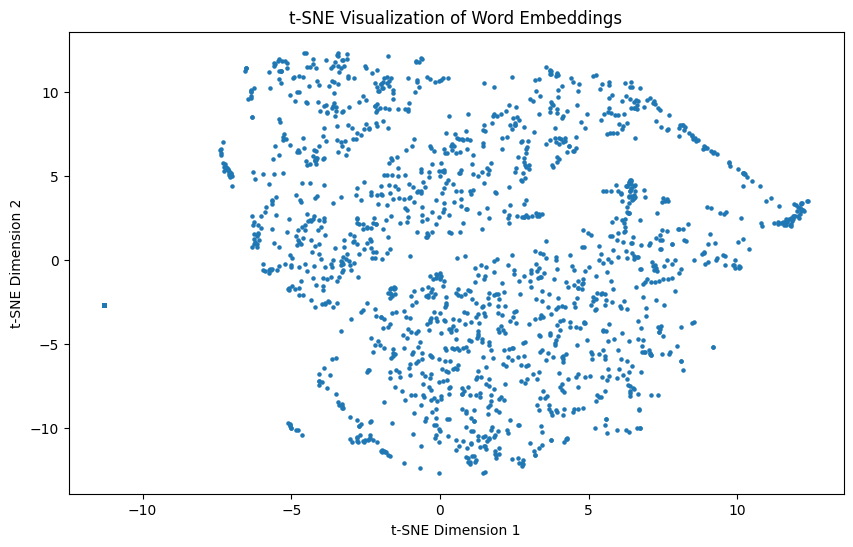

In [15]:
import ast
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE 
import numpy as np  
import json

word_embeddings_copy = db_get_df("word_embeddings",["word_embeddings"])
print(json.loads(word_embeddings_copy["word_embeddings"][0]))
word_embeddings_copy=[json.loads(embedding) for embedding in tqdm(word_embeddings_copy["word_embeddings"])]
# Verwenden Sie 'ast.literal_eval', um Zeichenketten in Listen umzuwandeln
#word_embeddings_copy = word_embeddings_copy.map(ast.literal_eval)

# Wandeln Sie die Listen von Listen in ein Numpy-Array um
word_embeddings = np.array(word_embeddings_copy)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_embedded = tsne.fit_transform(word_embeddings)
plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=5)
plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show() 


100%|██████████| 2433/2433 [00:00<00:00, 3849.63it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


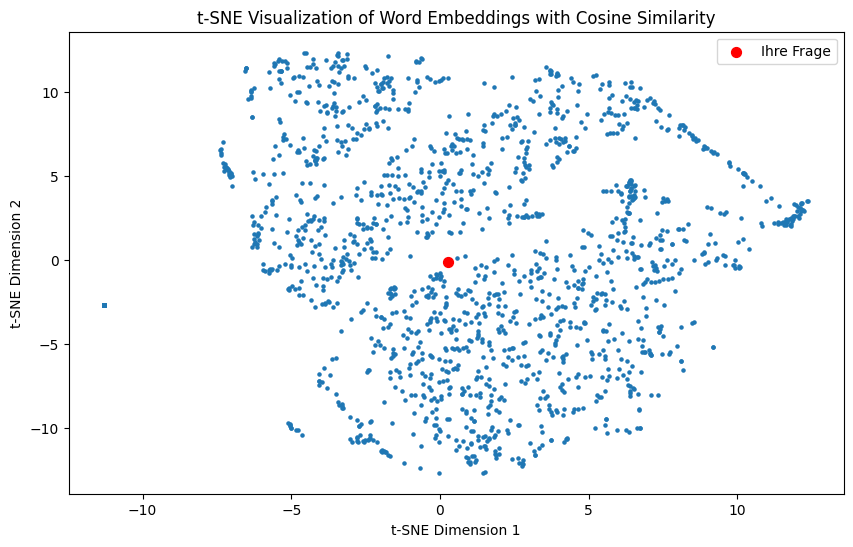

In [98]:
import ast
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE 
import numpy as np  
import json
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Funktion zur Extraktion von Word Embeddings für die Frage
def get_word_embedding(question, model_name='bert-base-uncased'):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    tokens = tokenizer(question, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
        question_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return question_embedding

# Laden der Word Embeddings
word_embeddings_copy = db_get_df("word_embeddings", ["word_embeddings"])
word_embeddings_copy = [json.loads(embedding) for embedding in tqdm(word_embeddings_copy["word_embeddings"])]
word_embeddings = np.array(word_embeddings_copy)

# Extrahieren der Embeddings für die Frage
question_text = "88?"
question_embedding = get_word_embedding(question_text)

# Berechnen der Kosinus-Ähnlichkeit zwischen der Frage und den anderen Word Embeddings
similarities = cosine_similarity(word_embeddings, [question_embedding])

# 'similarities' ist jetzt ein Array mit den Kosinus-Ähnlichkeiten zwischen der Frage und den anderen Word Embeddings.

# Kombinieren Sie die t-SNE-Komponenten mit den Kosinus-Ähnlichkeiten
combined_features = np.column_stack((X_embedded, similarities))

# Visualisierung
plt.figure(figsize=(10, 6))
plt.scatter(combined_features[:, 0], combined_features[:, 1], s=5)
plt.scatter(question_embedding[0], question_embedding[1], color='red', s=50, label='Ihre Frage')
plt.title("t-SNE Visualization of Word Embeddings with Cosine Similarity")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()


c:\Users\lizab\projects\daibl-2\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassi

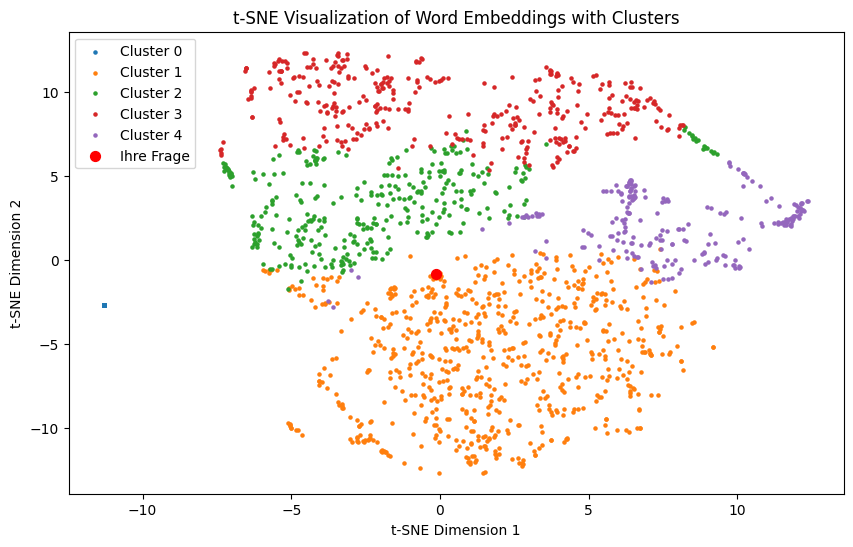

In [104]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Annahme: X_embedded ist Ihre t-SNE-Visualisierung
# Annahme: word_embeddings ist Ihre Matrix der Word Embeddings
# Annahme: question_text ist Ihre Frage
# Annahme: n_clusters ist die Anzahl der gewünschten Cluster
question_text = "wie viele Studiengänge gibt es?"

# Schritt 1: Clustering durchführen
kmeans = KMeans(n_clusters=5, random_state=0)
cluster_labels = kmeans.fit_predict(word_embeddings)

# Schritt 3: Berechnen der Ähnlichkeit zur Frage
question_embedding = get_word_embedding(question_text)  # Verwenden Sie Ihre get_word_embedding Funktion
similarities = cosine_similarity(word_embeddings, [question_embedding])

# Schritt 4: Visualisierung aktualisieren
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.scatter(X_embedded[cluster_labels == i, 0], X_embedded[cluster_labels == i, 1], s=5, label=f'Cluster {i}')

# Farben entsprechend des Clusters für die Frage aktualisieren
question_cluster = np.argmax(similarities)
plt.scatter(X_embedded[question_cluster, 0], X_embedded[question_cluster, 1], s=50, color='red', label='Ihre Frage')

plt.title("t-SNE Visualization of Word Embeddings with Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()


In [16]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)  # Specify the number of clusters you want
cluster_labels = kmeans.fit_predict(word_embeddings)


c:\Users\lizab\projects\daibl-2\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/2433 [5:29:16<?, ?it/s]


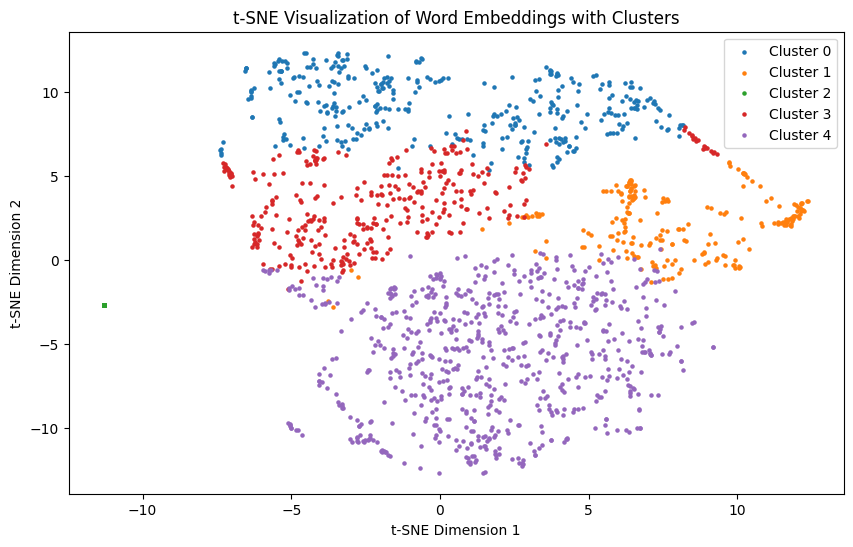

In [18]:
plt.figure(figsize=(10, 6))
for i in range(len(np.unique(cluster_labels))):
    plt.scatter(X_embedded[cluster_labels == i, 0], X_embedded[cluster_labels == i, 1], s=5, label=f'Cluster {i}')

plt.title("t-SNE Visualization of Word Embeddings with Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

In [20]:
# Call the db_get_df function to get the DataFrame
df = db_get_df()

# Print the first 2 rows of the DataFrame
first_2_rows = df.head(2)
print(first_2_rows)


                                            filename  \
0  data/htmlfiles/file_pressemitteilungen>aktuell...   
1  data/htmlfiles/file_karriere-bei-uns>ansprechp...   

                                               title  \
0  Pressemitteilungen – Technische Hochschule Nür...   
1  Ansprechpartner – Technische Hochschule Nürnbe...   

                                                text  \
0                                                      
1       Ansprechpartner Wissenschaftliche Mitarbe...   

                                              tokens  \
0                                                 []   
1  ["an", "##sp", "##re", "##ch", "##par", "##tne...   

                                     word_embeddings  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [-0.04521338641643524, 0.7916100025177002, 0.2...  


In [21]:
# Filter the indices of data points in Cluster 0
cluster0_indices = np.where(cluster_labels == 0)

# Get the corresponding rows from the DataFrame 'df'
cluster0_data_rows = df.iloc[cluster0_indices]

# Print the 'text' column for the data points in Cluster 0
for text in cluster0_data_rows['text']:
    print(text)


     Ansprechpartner Wissenschaftliche Mitarbeit, Wissenschaftsunterstützender Bereich und Ausbildung            Moritz  Meierhofer        telefon  +49 (0)911 5880 - 4125     email  moritz.meierhofer at th-nuernberg Punkt de     fax  +49 (0)911 5880 - 8129     Raum SC.205        Ansprechpartnerin Professuren            Violetta  Bassauer        telefon  +49 (0)911 5880 - 4147     email  violetta.bassauer at th-nuernberg Punkt de     fax  +49 (0)911 5880 - 8129     Raum SC.210         
       In den Fraunhofer Forschungsgruppen arbeiten Professorinnen und Professoren sowie wissenschaftliche Mitarbeiterinnen und Mitarbeiter gemeinsam an anwendungsorientierten Forschungsprojekten.            Future Engineering             Partikeltechnologien, Rohstoffinnovationen und Ressourceneffizienz                
       Link ins Intranet       
       Fachschaft-VT auf Instagram       
     Professor         Name  Kontakt            Frank  Opferkuch     Prof. Dr.-Ing.      telefon  +49 (0)911 5880 

In [59]:
import gensim
import spacy
import pandas as pd

# Annahme: Ihr DataFrame 'df' enthält eine Spalte 'text' mit den Textdaten.

# Anzahl der Cluster (angenommen, es sind 5 Cluster)
num_clusters = 5

for cluster_id in range(num_clusters):
    # Filtern Sie die Zeilen für den aktuellen Cluster
    cluster_data_rows = df

    # Laden des spaCy-Modells für die Textverarbeitung
    nlp = spacy.load("de_core_news_sm")

    # Benutzerdefinierte Stoppwortliste
    stopwords = {'www', 'th-nuernberg', 'nürnberg', 'nuernberg', 'th', 'technische', 'hochschule', 'ohm', 'de', 'punkt', 'simon'}

    # Tokenisieren und Lemmatisieren der Texte, Entfernen der Stoppwörter und Konvertieren in Strings
    processed_texts = []
    for text in cluster_data_rows['text']:
        doc = nlp(text)
        processed_tokens = []
        for token in doc:
            if token.text.lower() not in stopwords and token.pos_ in {'NOUN', 'PROPN'}:
                processed_tokens.append(token.text)
        processed_texts.append(' '.join(processed_tokens))

    # Erstellen eines Wörterbuchs und einer Textkorpus für das LDA-Modell
    text_tokens = [text.split() for text in processed_texts]
    dictionary = gensim.corpora.Dictionary(text_tokens)
    corpus = [dictionary.doc2bow(tokens) for tokens in text_tokens]

    # Anwendung des LDA-Modells
    lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

    # Anzeigen der Hauptthemen für den aktuellen Cluster
    print(f"Cluster {cluster_id} Topics:")
    for topic_id, topic in lda_model.print_topics():
        print(f"Topic {topic_id}: {topic}")
    print("\n")


Cluster 0 Topics:
Topic 0: 0.014*"Studium" + 0.007*"Praxis" + 0.007*"at" + 0.007*"Fakultät" + 0.006*"GmbH" + 0.005*"Studierende" + 0.005*"Betriebswirtschaft" + 0.005*"Verbundstudium" + 0.004*"Studierenden" + 0.004*"International"
Topic 1: 0.009*"Studierenden" + 0.008*"Inhalt" + 0.006*"Grundlagen" + 0.005*"Fähigkeit" + 0.005*"Lernziele" + 0.005*"Methoden" + 0.004*"Semester" + 0.004*"Abschluss" + 0.004*"Entwicklung" + 0.004*"Studiengang"
Topic 2: 0.038*"the" + 0.036*"and" + 0.032*"of" + 0.021*"Prof." + 0.016*"Dr." + 0.014*"for" + 0.012*"a" + 0.008*"The" + 0.006*"at" + 0.005*"with"
Topic 3: 0.042*"+49" + 0.042*"0)911" + 0.031*"at" + 0.025*"email" + 0.024*"telefon" + 0.018*"fax" + 0.016*"Prof." + 0.011*"Dr." + 0.008*"Kontakt" + 0.008*"Raum"
Topic 4: 0.011*"and" + 0.008*"of" + 0.008*"Uhr" + 0.007*"Prof." + 0.007*"Dr." + 0.006*"Innovation" + 0.004*"HORIZON" + 0.004*"Actions" + 0.004*"Deadline" + 0.004*"Type"


Cluster 1 Topics:
Topic 0: 0.010*"Studium" + 0.008*"Dr." + 0.007*"Prof." + 0.007*"

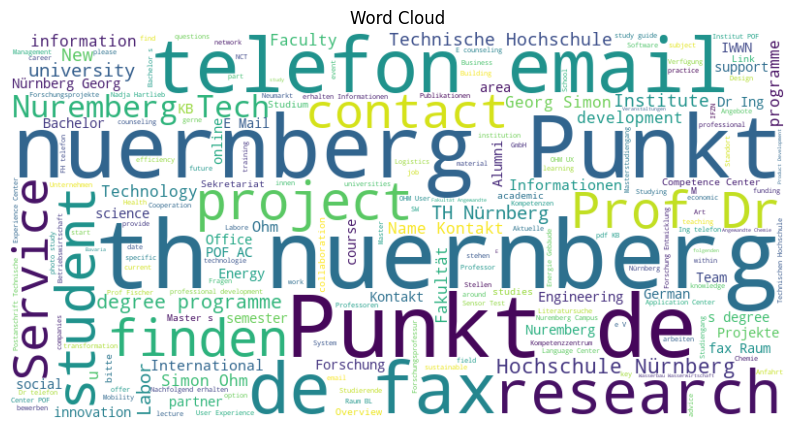

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join(processed_texts)  # 'processed_texts' ist die Liste der bereinigten Texte

# Erstellen der Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Anzeigen der Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

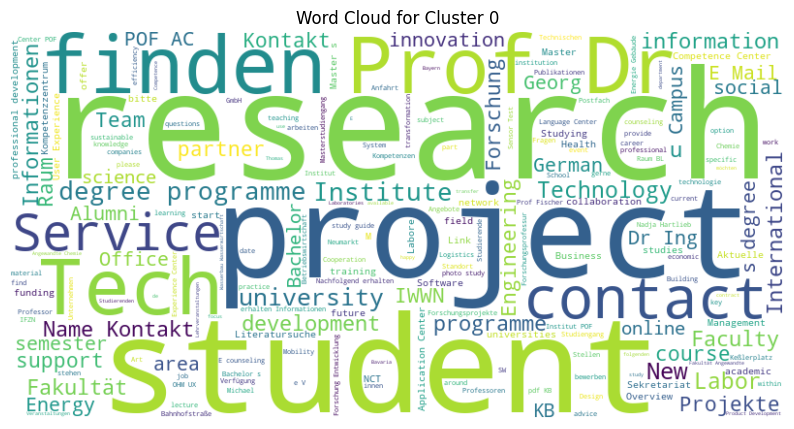

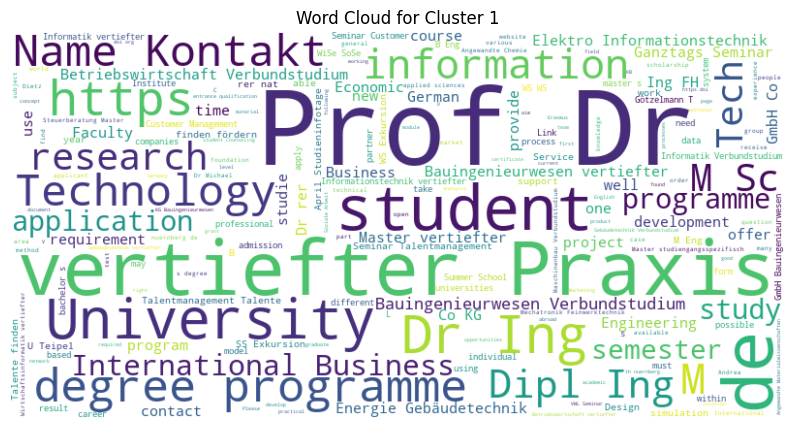

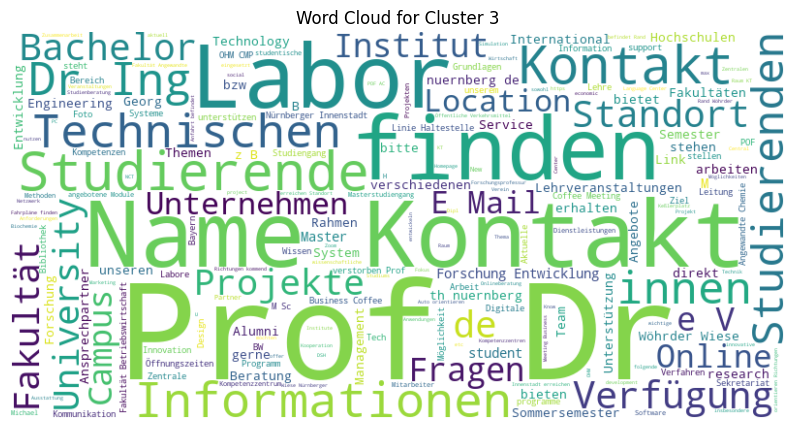

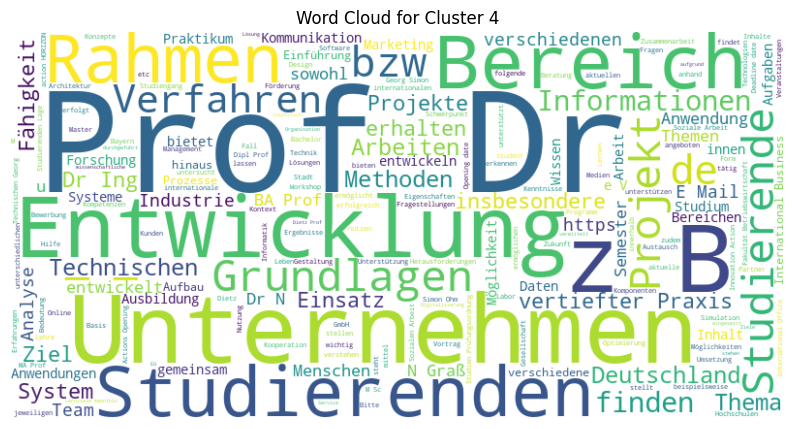

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Erstellen einer Liste von Stoppwörtern, einschließlich der URL und der benutzerdefinierten Wörter
stopwords = set(['www', 'th-nuernberg', 'nürnberg', 'nuernberg', 'th', 'technische', 'hochschule', 'ohm', 'de', 'punkt', 'simon','https','http','nuremberg','telefon','email','fax','Prof Dr','studium'])
stopwords = set(word.lower() for word in stopwords)  # In Kleinbuchstaben umwandeln

# Anzahl der Cluster (angenommen, es sind 5 Cluster)
num_clusters = 5

for cluster_id in range(num_clusters):
    if cluster_id == 2:
        continue
    # Filter the indices of data points in the current cluster
    cluster_indices = np.where(cluster_labels == cluster_id)

    # Get the corresponding rows from the DataFrame 'df'
    cluster_data_rows = df.iloc[cluster_indices]

    # Extract and preprocess text data
    texts = cluster_data_rows['text']
    nlp = spacy.load("de_core_news_sm")
    processed_texts = [' '.join([token.text for token in nlp(text) if not token.is_stop and token.text.lower() not in stopwords]) for text in texts]

    # Create a Word Cloud for the current cluster
    all_text = ' '.join(processed_texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

    # Display the Word Cloud for the current cluster
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.show()


In [ ]:
# database = 'discord_bot/scrap/html.sqlite'

# with sqlite3.connect(database) as con:
#     html_df.to_sql('html_with_embeddings', con, index=False, if_exists='replace')

In [ ]:
#dokument--> bert anwenden für jeden dokument
# question-bert anwenden
question="was macht Gallwitz?"
document=html_df["text"][1]






tokens = tokenizer.tokenize(question)
tokensDocument = tokenizer.tokenize(document)
segments_ids = [1] * len(tokens)
segmentsDocument_ids = [1] * len(tokensDocument)




token_idss = tokenizer.convert_tokens_to_ids(tokens)
tokenDocument_idss = tokenizer.convert_tokens_to_ids(tokensDocument)


tokens_tensor = torch.tensor([token_idss])
segments_tensors = torch.tensor([segments_ids])

tokensDocument_tensor = torch.tensor([tokenDocument_idss])
segmentsDocument_tensors = torch.tensor([segmentsDocument_ids])

with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

with torch.no_grad():
    outputs = model(tokensDocument_tensor, segmentsDocument_tensors)
    hiddenDocuments_states = outputs[2]

# print(token_idss)
# print(tokenDocument_idss)

print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))




Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 6
Number of hidden units: 768


In [ ]:
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings = token_embeddings.permute(1,0,2)

token_vecs_sum = []

# For each token in the sentence...
for token in token_embeddings:
    
    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 6 x 768


In [ ]:
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)
print ("Our final sentence embedding vector of shape:", sentence_embedding)


tokenDocuments_vecs = hiddenDocuments_states[-2][0]

# Calculate the average of all 22 token vectors.
sentenceDocument_embedding = torch.mean(tokenDocuments_vecs, dim=0)
print ("Our final sentence embedding vector of shape:", sentence_embedding)


NameError: name 'hidden_states' is not defined

In [ ]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(sentence_embedding, sentenceDocument_embedding)

print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for *different* meanings:  0.64
